In [7]:
import matplotlib.pyplot as plt
import geopy.distance
import networkx as nx
import pandas as pd
import numpy as np
import regex as re
import requests
import os

# defaults
adjacency_path = os.path.join("test_adjacency.csv")

# input
start_locations = ['Red, Washington County, UT', 'Blue, Chicot County, AR']
goal_locations = ['Red, San Diego, CA', 'Blue, Bienville Parish, LA']

# global vars
counties = {}
g = nx.Graph()

# classes
class County:
    def __init__(self, txt:str):
        self.name = txt.split(",")[0]
        self.state = txt.split(",")[1]
        self.neighbors = []
        self.parent = None

        self.g = np.inf # distance from start
        self.h = np.inf # heuristic distance from the goal
        self.f = self.g + self.h
    
    def add_neighbor(self, neighbor):
        if f"{self.name}, {self.state}" != f"{neighbor.name}, {neighbor.state}":
            self.neighbors.append(neighbor)

# reads the csv file and converts it into a dataframe
def read_neighbors_file(file_name: os) -> pd.DataFrame:
    return pd.read_csv(file_name)

# returns the unique values in a df[col_name]
def get_unique_list(df: pd.DataFrame, col_name: str) -> list:
    return list(set(df[col_name]))

# gets a list of text and returns a list of County objects
def make_object_list(lst: list) -> list:
    return [County(c) for c in lst]

# making the dataframe into objects and adding their neighbors
def preparing_objects(raw_df: pd.DataFrame) -> dict:
    unique_counties = get_unique_list(raw_df, 'countyname')
    county_objects = make_object_list(unique_counties) 
    counties_dict = {county.name + "," + county.state: county for county in county_objects}
    for _, record in raw_df.iterrows():
        county = record['countyname']
        neighbor = record['neighborname']
        cnty_object = counties_dict[county]
        neighbor_object = counties_dict[neighbor]
        cnty_object.add_neighbor(neighbor_object)
    return counties_dict

# build a graph using the counties and neighbors dicts
def add_to_graph() -> nx.Graph:
    g = nx.Graph()
    for county in counties.values():
        county_id = county.name + ',' + county.state
        # adds the county node if it doesn't already exist
        if county_id not in g.nodes:
            g.add_node(county_id, header=county_id, visited = False, object = counties[county_id])
        
        # connects the county node to its neighboring county nodes
        for neighbor in county.neighbors:
            neighbor_id = neighbor.name + ',' + neighbor.state
            # if the neighbor is already in the graph, connect them
            if neighbor_id in g.nodes:
                g.add_edge(county_id, neighbor_id)
            # if the neighbor is not in the graph, create it and then connect them
            else:
                g.add_node(neighbor_id, header=neighbor_id, visited = False, object = counties[neighbor_id])
                g.add_edge(county_id, neighbor_id)
    return g

# finds the shortest path from the starting locations to the goal location
# using a search method - an integer
# details_output = {0: showing only the paths, 1: prints the first iteration and the heuristic value of the first steps -> <value, value, value, ...>}
def find_path(starting_locations ,goal_locations ,search_method, detail_output):
    if (search_method == 1):
        paths = a_star(starting_locations, goal_locations)
        if paths: # the paths list isn't empty -> there is at least one path

             # i need here to put something with the detail_output
            pass
        else: # none means no path was found
            print('No path was found from the starting location to the ending locations. ')
    else: # will have other algorythems
        pass

# gets two names of counties and return the geographical distance between them in km
def heuristic_calc(county1: str, county2: str) -> float:
    # gets the county coordinates using it's name and state - using the attached url
    def get_county_coordinates(county_name: str) -> tuple:
        """
        Get the latitude and longitude coordinates of a state using its name.
        """
        url = f"https://nominatim.openstreetmap.org/search?q={county_name}&format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data:
                return float(data[0]['lat']), float(data[0]['lon'])
        return None
    coord1 = get_county_coordinates(county1)
    coord2 = get_county_coordinates(county2)
    return geopy.distance.geodesic(coord1, coord2).km

# preform a* search from a starting location to one of the ending locations in the goal list - all in the same color party
# i assume that len(starting_locations) == len(goal_locations)
def a_star(starting_locations: list, goal_locations: list) -> list:
    for start_loc in starting_locations:
        frontier = [] # will contain only the nodes that has been visited at
        explored = [] # will contain only the nodes that has been visited and expanded

        # initiallize the frontier with the start location
        frontier.append(start_loc)

# returns a list for the same color
def get_list_per_color(lst: list, pattern: re.Pattern) -> list:
    return [loc.replace('Red, ','').replace('Blue, ', '') for loc in lst if re.search(pattern, loc)]

if __name__ == "__main__":
    # initiallizing
    raw_df = read_neighbors_file(adjacency_path)
    counties = preparing_objects(raw_df) # dict: {county.name, county.state: county object}. this is the same dict as neighbors so it is enough for one of them
    g = add_to_graph() # initiallizing the graph
    
    # dividing the starting locations and goal locations into different lists according to their colors.
    red_starts = get_list_per_color(start_locations, r'Red, \w*')
    red_goals = get_list_per_color(goal_locations, r'Red, \w*')
    blue_starts = get_list_per_color(start_locations, r'Blue, \w*')
    blue_goals = get_list_per_color(goal_locations, r'Blue, \w*')

    # red parties paths
    red_paths = find_path(red_starts, red_goals, 1, 0)
    # blue_paths = find_path(blue_starts, blue_goals, 1, 0)


Graph with 17 nodes and 24 edges
No path was found from the starting location to the ending locations. 


# Vizualisation


Iron County, UT
Washington County, UT
Clark County, NV
Mohave County, AZ
San Bernardino County, CA
La Paz County, AZ
Imperial County, CA
San Diego County, CA
Inyo County, CA
Kern County, CA
Los Angeles County, CA
Orange County, CA
Riverside County, CA
Yavapai County, AZ
Coconino County, AZ
Kane County, UT
Lincoln County, NV


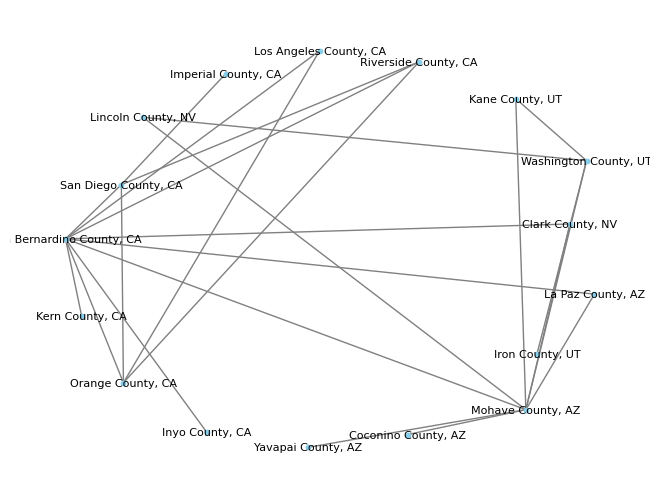

In [8]:

# Create an empty graph
g = nx.Graph()

for county in counties.values():
    county_id = county.name + ',' + county.state
    # adds the county node if it doesn't already exist
    if county_id not in g.nodes:
        g.add_node(county_id, header=county_id, visited = False)
    
    # connects the county node to its neighboring county nodes
    for neighbor in county.neighbors:
        neighbor_id = neighbor.name + ',' + neighbor.state
        # if the neighbor is already in the graph, connect them
        if neighbor_id in g.nodes:
            g.add_edge(county_id, neighbor_id)
        # if the neighbor is not in the graph, create it and then connect them
        else:
            g.add_node(neighbor_id, header=neighbor_id, visited = False)
            g.add_edge(county_id, neighbor_id)

for node_id in g.nodes:
    print(node_id)

# Compute the layout for the graph
pos = nx.spring_layout(g, k=5) # , iterations=100

# Draw the graph
nx.draw(g, pos, labels=nx.get_node_attributes(g, 'header'), with_labels=True, node_color='skyblue', node_size=10, font_size=8, edge_color='gray')

# Display the plot
plt.show()
